In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, confusion_matrix
from rembg import remove

In [2]:
def resize_image(image, target_size):

    original_height, original_width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * original_width / target_width)
            original_y = int(i * original_height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (150, 150))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [3]:
images, filenames,labels, path, distribusi = insertGambar("Train/") 
print("Data: ", len(images))
print("Label: ", len(labels))
print("Filenames: ", len(filenames))
print("Data Distribution: ", distribusi)

Burgerfix


 53%|█████▎    | 100/190 [00:02<00:01, 47.88it/s]


Donutfix


 62%|██████▎   | 100/160 [00:02<00:01, 40.59it/s]


Friesfix


 59%|█████▉    | 100/170 [00:01<00:01, 50.64it/s]

Data:  300
Label:  3
Filenames:  300
Data Distribution:  {'Burgerfix': 190, 'Donutfix': 160, 'Friesfix': 170}


In [4]:
def display(gambar, titel,rows,columns):
    fig = plt.figure(figsize=(3*columns, rows*2)) 
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1) 
        plt.imshow(gambar[i], cmap='gray')
        plt.axis('off') 
        plt.title(titel[i])

In [5]:
def removeBackground(data):
    removed_data = []
    for i in tqdm(range(len(data))):
        removed_data.append(remove(data[i]))
    return removed_data

removeData = removeBackground(images)

100%|██████████| 300/300 [09:41<00:00,  1.94s/it]


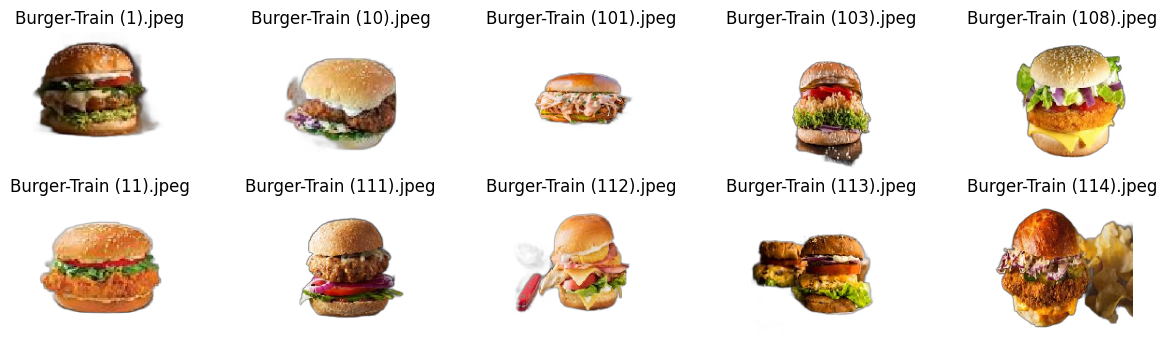

In [6]:
display(removeData, filenames, 2, 5)

In [7]:
def gray_scaling(data):
    grayData = []
    for img in data:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        grayData.append(gray)
    return grayData

gray_img = gray_scaling(removeData)

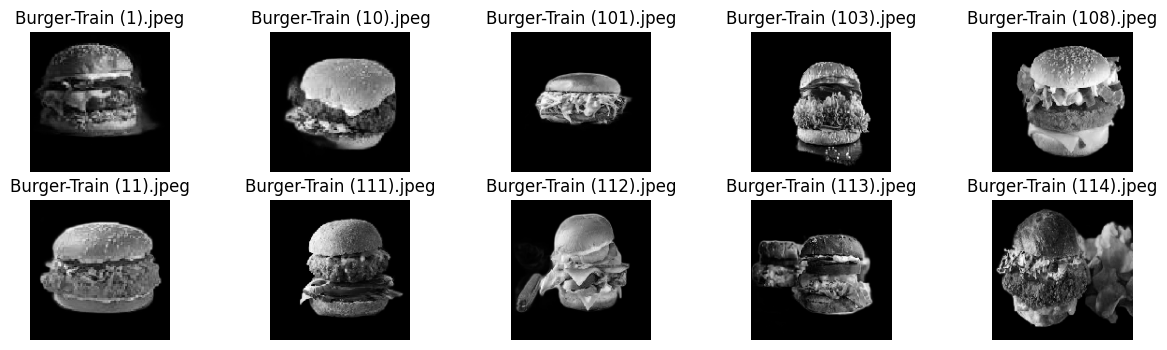

In [8]:
display(gray_img, filenames, 2, 5)

In [9]:
def normalisasi(data):
    normData = []
    for img in data:
        norm = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
        normData.append(norm)
    return normData

normData = normalisasi(gray_img)


### pre

In [10]:
def meanFilter(image):
    heightImage, widthImage = image.shape
    padImage = np.pad(image, (1,1), mode='edge')
    kernel = np.zeros((3,3))
    result = np.zeros([heightImage, widthImage]).astype(int)
    for i in range(heightImage):
        for j in range(widthImage):
            temp = 0
            # if padImage[i, j] == 0:
            #     result[i][j] = 0
            #     continue
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    temp += padImage[i+k, j+l]
            result[i, j] = int(temp/(kernel.shape[0]*kernel.shape[1]))
    return result

def meanFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = meanFilter(img)
        hasil.append(gambar)
    return hasil

In [11]:
meanData = meanFilterData(normData)

100%|██████████| 300/300 [00:49<00:00,  6.06it/s]


In [12]:
def convGradient(image, kernel):
    centerx, centery = int((kernel.shape[0] - 1)/2), int((kernel.shape[1] - 1)/2)
    padding =  np.pad(array = image, pad_width = ((centerx, kernel.shape[0]-1-centerx), (centery, kernel.shape[1]-1-centery)), mode ="constant") 

    result = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]): 
            for k in range(kernel.shape[0]): 
                for l in range(kernel.shape[1]): 
                    result[i,j] += padding[i+k, j+l] * kernel[k,l] 
    return result

In [13]:
def sobel(data):
    sobelData = []
    gx = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gy = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

    for img in tqdm(data):
        x = convGradient(img, gx)
        y = convGradient(img, gy)
        gradient = np.sqrt(x**2 + y**2)
        gradient = gradient.astype(np.uint8)
        sobelData.append(gradient)
    return sobelData

sobelData = sobel(meanData)

100%|██████████| 300/300 [02:53<00:00,  1.73it/s]


In [14]:
def ekualisasi(img):
    histogram = np.zeros(256).astype(int)
    hImg, wImg = img.shape

    for i in range(hImg):
        for j in range(wImg):
            value = img[i, j]
            histogram[value] += 1
    
    dist_kumulatif = np.zeros(256).astype(int)
    dist_kumulatif[0] = histogram[0]
    for i in range(1, 256):
        dist_kumulatif[i] = dist_kumulatif[i-1] + histogram[i]
    
    target_value = dist_kumulatif * (256-1) / (hImg * wImg)
    target_value = np.floor(target_value).astype(int)

    result = target_value[img]
    return result

def ekualisasiData(data):
    hasil = []
    for img in data:
        gambar = ekualisasi(img)
        hasil.append(gambar)
    return hasil

In [15]:
ekualisasiData = ekualisasiData(sobelData)

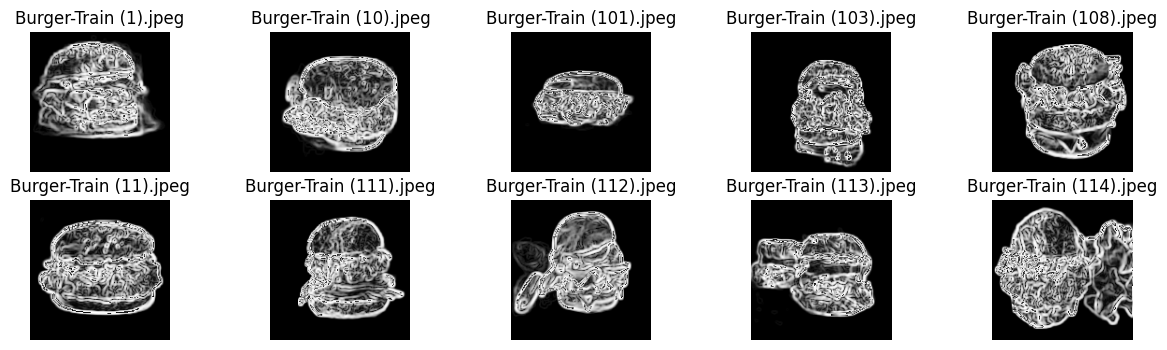

In [16]:
display(ekualisasiData, filenames, 2, 5)

### batas

In [17]:
def matriksTransformasi(matriks):
    hasil = np.zeros(matriks.shape)
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            hasil[i][j] = matriks[j][i]
    return hasil
def sum(matriks):
    hasil = 0
    for i in range(len(matriks)):
        for j in range(len(matriks[0])):
            hasil += matriks[i][j]
    return hasil

In [18]:
def derajat(img, derajat):
    max = int(np.max(img))
    temp=np.zeros([max+1,max+1])
    if derajat == 0:
        for i in range (len(img)):
            for j in range (len(img[0])-1):
                temp[img[i,j],img[i,j+1]] += 1
    elif derajat == 45:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i+1,j],img[i,j+1]] += 1
    elif derajat == 90:
        for i in range (len (img)-1):
            for j in range (len (img[0])):
                temp[img[i+1,j],img[i,j]] += 1
    elif derajat == 135:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i,j],img[i+1,j+1]] += 1
    hasil = temp+matriksTransformasi(temp)
    total = sum(hasil)
    for i in range (len (hasil)):
        for j in range (len (hasil)):
            hasil[i,j]/=total
    return hasil

In [19]:
def GLCM(image):
    hasil = []
    for img in tqdm(image):
        if np.min(img) < 0:
            continue
        data = []
        data.append(derajat(img,0))
        data.append(derajat(img,45))
        data.append(derajat(img,90))
        data.append(derajat(img,135))
        hasil.append(data)    
    return hasil

In [20]:
hasil = GLCM(ekualisasiData)

100%|██████████| 300/300 [02:05<00:00,  2.38it/s]


In [21]:
def contrast (data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*pow(i-j,2)
    return hasil
def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*abs(i-j)
    return hasil
def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=(data[i,j]/(1+pow(i-j,2)))
    return hasil
def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil
def correlation(data):
    mean = np.zeros((2))
    std = np.zeros((2))
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean[0] += i*data[i,j]
            mean[1] += j*data[i,j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std[0] += pow(i-mean[0],2)*data[i,j]
            std[1] += pow(j-mean[1],2)*data[i,j]
    std[0] = math.sqrt(std[0])
    std[1] = math.sqrt(std[1])
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i-mean[0])*(j-mean[1])*data[i,j]/(std[0]*std[1])
    return hasil
def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy
def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [22]:
def ekstraksi(data):
    result = []
    for i in tqdm(range(len(data))):
        extracted_data = []
        for j in range(len(data[i])):
            contrast_val = contrast(data[i][j])
            extracted_data.append(contrast_val)
        for j in range(len(data[i])):
            dissimilarity_val = dissimilarity(data[i][j])
            extracted_data.append(dissimilarity_val)
        for j in range(len(data[i])):
            homogeneity_val = homogeneity(data[i][j])
            extracted_data.append(homogeneity_val)
        for j in range(len(data[i])):
            energy_val = energy(data[i][j])
            extracted_data.append(energy_val)
        for j in range(len(data[i])):
            correlation_val = correlation(data[i][j])
            extracted_data.append(correlation_val)
        for j in range(len(data[i])):
                asm_val = asm(data[i][j])
                extracted_data.append(asm_val)
                entropy_val = entropy(data[i][j])
                extracted_data.append(entropy_val)
        result.append(extracted_data)
    return result

In [23]:
hasilGLCM = ekstraksi(hasil)

100%|██████████| 300/300 [14:37<00:00,  2.93s/it]


In [24]:
for i in range (len(hasilGLCM)):
    hasilGLCM[i].append(path[i])

In [72]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
headers = []
for fitur in fiturs:
    headers.extend([f'{fitur}_0', f'{fitur}_45', f'{fitur}_90', f'{fitur}_135'])
for angle in angles:
    headers.extend([f'asm_{angle}', f'entropy_{angle}'])
headers.append('Path')
df = pd.DataFrame(hasilGLCM, columns=headers)
df.to_csv('sesudahPreprocessing100ke2.csv', index=False)

In [98]:
from sklearn.decomposition import PCA
df = pd.read_csv('sesudahPreprocessing100ke2.csv')
x = df.drop('Path', axis=1)
y = df['Path']

pca = PCA(n_components=25)
x = pca.fit_transform(x)

In [90]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

In [92]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

In [97]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(xTrain, yTrain)
knn_pred = knn.predict(xTest)
print('Accuracy:', accuracy_score(yTest, knn_pred))

svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(xTrain, yTrain)
svm_pred = svm.predict(xTest)
print('Accuracy:', accuracy_score(yTest, svm_pred))

rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(xTrain, yTrain)
rf_pred = rfc.predict(xTest)
print('Accuracy:', accuracy_score(yTest, rf_pred))

Accuracy: 0.6166666666666667
Accuracy: 0.7166666666666667
Accuracy: 0.7


In [58]:
knn = KNeighborsClassifier()
svm = SVC()
rf = RandomForestClassifier()

knn.fit(xTrain, yTrain)
svm.fit(xTrain, yTrain)
rf.fit(xTrain, yTrain)

yPredKnn = knn.predict(xTest)
yPredSvm = svm.predict(xTest)
yPredRf = rf.predict(xTest)

precision_knn = precision_score(yTest, yPredKnn, average='weighted')
recall_knn = recall_score(yTest, yPredKnn, average='weighted')
f1_knn = f1_score(yTest, yPredKnn, average='weighted')

precision_svm = precision_score(yTest, yPredSvm, average='weighted')
recall_svm = recall_score(yTest, yPredSvm, average='weighted')
f1_svm = f1_score(yTest, yPredSvm, average='weighted')

precision_rf = precision_score(yTest, yPredRf, average='weighted')
recall_rf = recall_score(yTest, yPredRf, average='weighted')
f1_rf = f1_score(yTest, yPredRf, average='weighted')


hasil = pd.DataFrame()
hasil['Model'] = ['KNN', 'SVM', 'Random Forest']
hasil['Accuracy'] = [accuracy_score(yTest, knn_pred), accuracy_score(yTest, svm_pred), accuracy_score(yTest, rf_pred)]
hasil['Precision'] = [precision_knn, precision_svm, precision_rf]
hasil['Recall'] = [recall_knn, recall_svm, recall_rf]
hasil['F1-Score'] = [f1_knn, f1_svm, f1_rf]
print(hasil)

           Model  Accuracy  Precision    Recall  F1-Score
0            KNN  0.616667   0.700128  0.550000  0.506102
1            SVM  0.716667   0.716667  0.716667  0.716667
2  Random Forest  0.700000   0.734057  0.716667  0.717615
